In [8]:
import mynn as nn
from draw_tools.plot import plot
import numpy as np
from struct import unpack
import gzip
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage import rotate, shift  # 新增数据增强依赖

# 新增数据增强函数
def augment_image(image, max_angle=10, max_shift=2):
    """应用随机旋转和平移增强"""
    img = image.reshape(28, 28)
    
    # 随机旋转
    angle = np.random.uniform(-max_angle, max_angle)
    rotated = rotate(img, angle=angle, reshape=False)
    
    # 随机平移
    dx = np.random.randint(-max_shift, max_shift+1)
    dy = np.random.randint(-max_shift, max_shift+1)
    shifted = shift(rotated, (dy, dx), mode='constant', cval=0.0)
    
    # 归一化并展平
    shifted = np.clip(shifted, 0, 1)
    return shifted.flatten()

# fixed seed for experiment
np.random.seed(309)

train_images_path = r'.\dataset\MNIST\train-images-idx3-ubyte.gz'
train_labels_path = r'.\dataset\MNIST\train-labels-idx1-ubyte.gz'

with gzip.open(train_images_path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        train_imgs=np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28*28)
    
with gzip.open(train_labels_path, 'rb') as f:
        magic, num = unpack('>2I', f.read(8))
        train_labs = np.frombuffer(f.read(), dtype=np.uint8)


# choose 10000 samples from train set as validation set.
idx = np.random.permutation(np.arange(num))
# save the index.
with open('idx.pickle', 'wb') as f:
        pickle.dump(idx, f)
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:10000]
valid_labs = train_labs[:10000]
train_imgs = train_imgs[10000:]
train_labs = train_labs[10000:]

# normalize from [0, 255] to [0, 1]
train_imgs = train_imgs / train_imgs.max()
valid_imgs = valid_imgs / valid_imgs.max()


# 新增数据增强步骤 ==========================================
print("Applying data augmentation...")
augmented_images = []
augmented_labels = []

# 对每个训练样本生成增强版本
for img, label in zip(train_imgs, train_labs):
    # 保留原始样本
    augmented_images.append(img)
    augmented_labels.append(label)
    
    # 生成3个增强样本
    for _ in range(3):
        aug_img = augment_image(img)
        augmented_images.append(aug_img)
        augmented_labels.append(label)

train_imgs = np.array(augmented_images)
train_labs = np.array(augmented_labels)
print(f"Augmented dataset size: {len(train_imgs)} samples")

Applying data augmentation...
Augmented dataset size: 200000 samples


In [ ]:
def train_model_mlp(nHidden=[128], lr=0.5, epochs=20, patience=5):
    # 模型结构：输入层 + 隐藏层 + 输出层
    size_list = [train_imgs.shape[1]] + nHidden + [10]
    lambda_list = [1e-4] * (len(nHidden) + 1)  # 每层一个lambda
    
    # 初始化组件
    model = nn.models.Model_MLP(size_list, 'ReLU', lambda_list, dropout_rates=None)
    opt = nn.optimizer.MomentGD(init_lr=lr, model=model,mu=0.9)
    scheduler = nn.lr_scheduler.MultiStepLR(opt, milestones=[800, 2400, 4000], gamma=0.5)
    loss_fn = nn.op.MultiCrossEntropyLoss(model=model)
    
    
    # 训练运行器
    trainer = nn.runner.RunnerM(
        model=model,
        optimizer=opt,
        metric=nn.metric.accuracy,
        loss_fn=loss_fn,
        batch_size=32,
        scheduler=scheduler
    )
    
    # 执行训练
    trainer.train(
        train_set=[train_imgs, train_labs],
        dev_set=[valid_imgs, valid_labs],
        num_epochs=epochs,
        log_iters=100,
        save_dir=f'./saved_models/data_augmentation',
        patience=patience
    )
    
    # 绘制训练曲线
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(trainer.train_loss, label='Train Loss')
    axes[0].plot(trainer.dev_loss, label='Val Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()
    
    axes[1].plot(trainer.train_scores, label='Train Acc')
    axes[1].plot(trainer.dev_scores, label='Val Acc')
    axes[1].set_title('Accuracy Curve')
    axes[1].legend()
    
    plt.show()
    
    return trainer

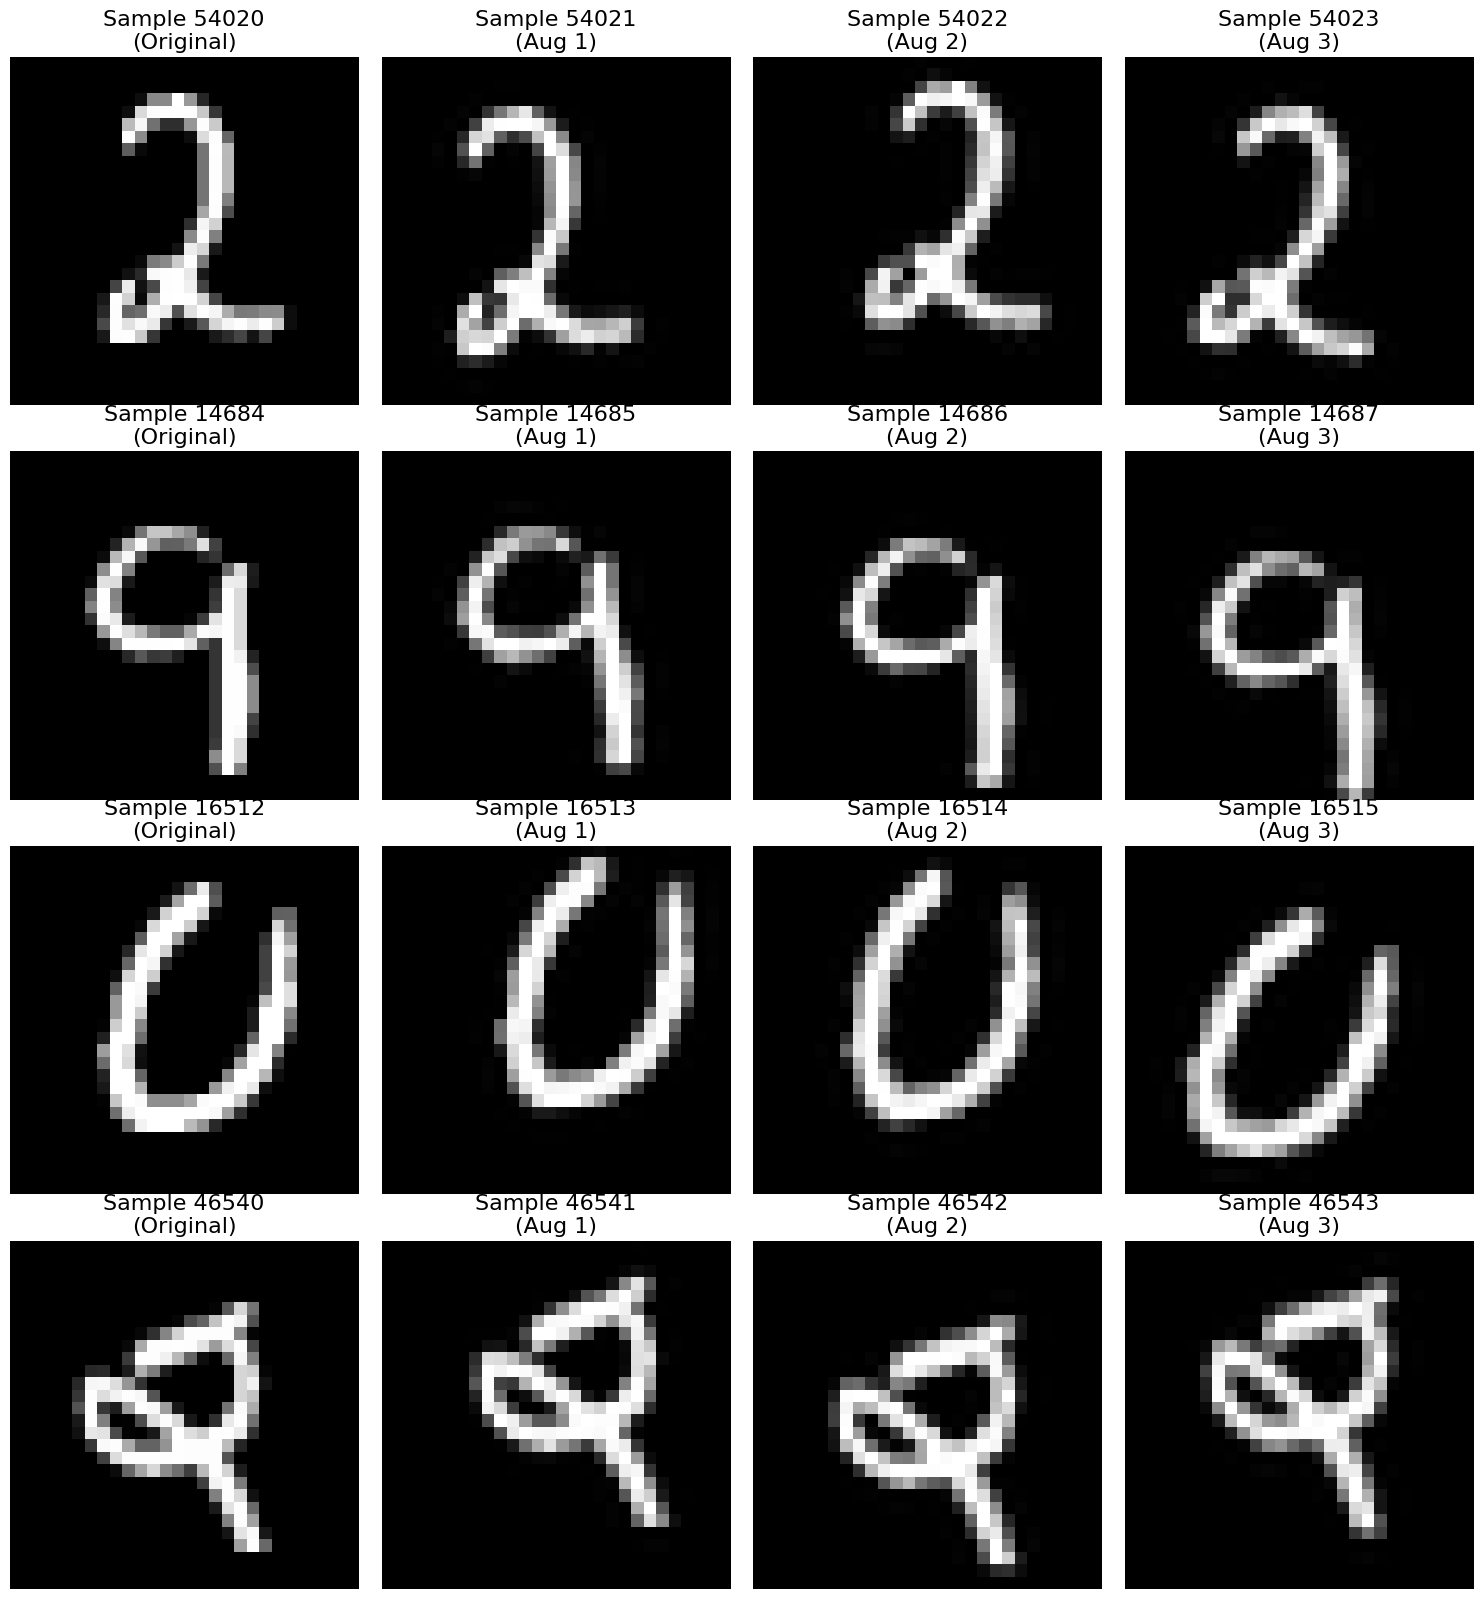

In [11]:
# 可视化多组增强样本
num_groups = 4  # 展示4组不同的样本
samples_per_group = 4  # 每组包含原始+3增强

# 随机选择4个不同的样本索引
sample_indices = np.random.choice(len(train_imgs)//samples_per_group, num_groups, replace=False) * samples_per_group

# 创建可视化布局
fig, axes = plt.subplots(num_groups, samples_per_group, figsize=(15, 4*num_groups))

for row, start_idx in enumerate(sample_indices):
    # 每组显示原始样本+其3个增强
    for col in range(samples_per_group):
        ax = axes[row, col] if num_groups > 1 else axes[col]
        img_idx = start_idx + col
        
        ax.imshow(train_imgs[img_idx].reshape(28,28), cmap='gray')
        ax.set_title(f"Sample {img_idx}\n({'Original' if col==0 else f'Aug {col}'})", fontsize=16)
        ax.axis('off')

plt.tight_layout(pad=1.0)  # 增加子图间距
plt.show()

# nHidden=[128]

## max_angle=10, max_shift=2

Epoch: 1/20
[Train] Loss: 0.7823, Score: 0.8077
[Dev]   Loss: 0.2679, Score: 0.9240

Epoch: 2/20
[Train] Loss: 0.3601, Score: 0.8949
[Dev]   Loss: 0.2221, Score: 0.9418

Epoch: 3/20
[Train] Loss: 0.3022, Score: 0.9180
[Dev]   Loss: 0.1905, Score: 0.9521

Epoch: 4/20
[Train] Loss: 0.2715, Score: 0.9302
[Dev]   Loss: 0.1786, Score: 0.9594

Epoch: 5/20
[Train] Loss: 0.2546, Score: 0.9369
[Dev]   Loss: 0.1679, Score: 0.9636

Epoch: 6/20
[Train] Loss: 0.2445, Score: 0.9408
[Dev]   Loss: 0.1632, Score: 0.9656

Epoch: 7/20
[Train] Loss: 0.2386, Score: 0.9435
[Dev]   Loss: 0.1594, Score: 0.9669

Epoch: 8/20
[Train] Loss: 0.2344, Score: 0.9446
[Dev]   Loss: 0.1576, Score: 0.9675

Epoch: 9/20
[Train] Loss: 0.2311, Score: 0.9457
[Dev]   Loss: 0.1543, Score: 0.9678

Epoch: 10/20
[Train] Loss: 0.2291, Score: 0.9465
[Dev]   Loss: 0.1514, Score: 0.9700

Epoch: 11/20
[Train] Loss: 0.2266, Score: 0.9469
[Dev]   Loss: 0.1517, Score: 0.9691

Epoch: 12/20
[Train] Loss: 0.2252, Score: 0.9475
[Dev]   Loss: 

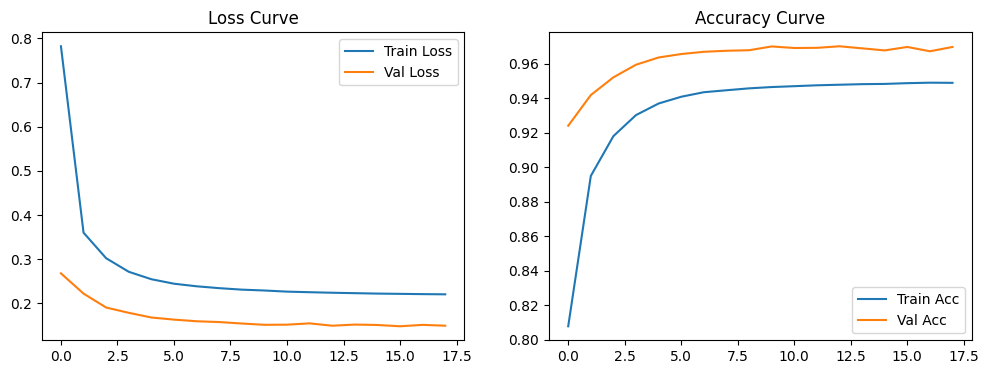

In [ ]:
trainer=train_model_mlp()

# nHidden=[256]

## max_angle=10, max_shift=2

Epoch: 1/20
[Train] Loss: 0.7771, Score: 0.8562
[Dev]   Loss: 0.2182, Score: 0.9395

Epoch: 2/20
[Train] Loss: 0.2979, Score: 0.9143
[Dev]   Loss: 0.1958, Score: 0.9483

Epoch: 3/20
[Train] Loss: 0.2717, Score: 0.9272
[Dev]   Loss: 0.1807, Score: 0.9559

Epoch: 4/20
[Train] Loss: 0.2557, Score: 0.9353
[Dev]   Loss: 0.1717, Score: 0.9603

Epoch: 5/20
[Train] Loss: 0.2448, Score: 0.9405
[Dev]   Loss: 0.1645, Score: 0.9642

Epoch: 6/20
[Train] Loss: 0.2374, Score: 0.9431
[Dev]   Loss: 0.1626, Score: 0.9640

Epoch: 7/20
[Train] Loss: 0.2317, Score: 0.9455
[Dev]   Loss: 0.1594, Score: 0.9673

Epoch: 8/20
[Train] Loss: 0.2280, Score: 0.9468
[Dev]   Loss: 0.1562, Score: 0.9654

Epoch: 9/20
[Train] Loss: 0.2253, Score: 0.9472
[Dev]   Loss: 0.1522, Score: 0.9673

Epoch: 10/20
[Train] Loss: 0.2227, Score: 0.9487
[Dev]   Loss: 0.1484, Score: 0.9686

Epoch: 11/20
[Train] Loss: 0.2213, Score: 0.9487
[Dev]   Loss: 0.1508, Score: 0.9683

Epoch: 12/20
[Train] Loss: 0.2198, Score: 0.9495
[Dev]   Loss: 

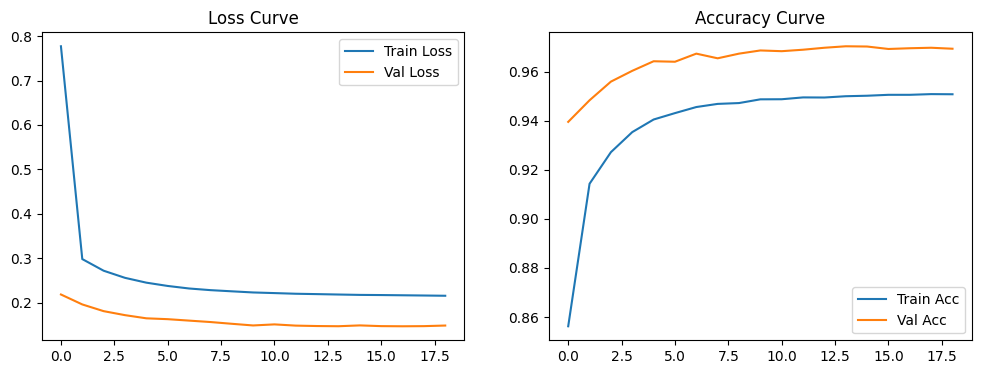

In [ ]:
trainer=train_model_mlp(nHidden=[256])

# cnn

In [16]:
# 在现有预处理基础上增加维度扩展
train_imgs = train_imgs.reshape(-1, 1, 28, 28)  # 转换为[N, C, H, W]格式
valid_imgs = valid_imgs.reshape(-1, 1, 28, 28)

def train_model_cnn(conv_configs,fc_configs,use_global_avg_pool,epochs,save_dir, patience=5):
    # 初始化CNN模型
    model = nn.models.Model_CNN(
        conv_configs=conv_configs,
        fc_configs=fc_configs,
        act_func='ReLU',
        use_global_avg_pool=use_global_avg_pool
    )
    
    opt = nn.optimizer.MomentGD(init_lr=0.5,model=model,mu=0.9)
    scheduler = nn.lr_scheduler.MultiStepLR(opt, milestones=[7500, 75000], gamma=0.5)
    loss_fn = nn.op.MultiCrossEntropyLoss(model=model)
    metric = nn.metric.accuracy
    
    trainer = nn.runner.RunnerM(
        model=model,
        optimizer=opt,
        metric=metric,
        loss_fn=loss_fn,
        batch_size=64,
        scheduler=scheduler
    )

    trainer.train(
        train_set=(train_imgs, train_labs),
        dev_set=(valid_imgs, valid_labs),
        num_epochs=epochs,
        log_epochs=1,  # 每1个epoch打印一次日志
        save_dir=save_dir,
        patience=patience  # 传递早停参数
    )


    # 绘制训练曲线
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(trainer.train_loss, label='Train Loss')
    axes[0].plot(trainer.dev_loss, label='Val Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()
    
    axes[1].plot(trainer.train_scores, label='Train Acc')
    axes[1].plot(trainer.dev_scores, label='Val Acc')
    axes[1].set_title('Accuracy Curve')
    axes[1].legend()
    
    plt.show()
    
    return trainer

Epoch: 1/100
[Train] Loss: 1.5214, Score: 0.4848
[Dev]   Loss: 0.3683, Score: 0.8911

Epoch: 2/100
[Train] Loss: 0.4802, Score: 0.8486
[Dev]   Loss: 0.2090, Score: 0.9398

Epoch: 3/100
[Train] Loss: 0.3438, Score: 0.8937
[Dev]   Loss: 0.1703, Score: 0.9506

Epoch: 4/100
[Train] Loss: 0.3050, Score: 0.9073
[Dev]   Loss: 0.1740, Score: 0.9484

Epoch: 5/100
[Train] Loss: 0.2843, Score: 0.9136
[Dev]   Loss: 0.1677, Score: 0.9450

Epoch: 6/100
[Train] Loss: 0.2685, Score: 0.9183
[Dev]   Loss: 0.1605, Score: 0.9522

Epoch: 7/100
[Train] Loss: 0.2596, Score: 0.9210
[Dev]   Loss: 0.1354, Score: 0.9609

Epoch: 8/100
[Train] Loss: 0.2486, Score: 0.9246
[Dev]   Loss: 0.1518, Score: 0.9542

Epoch: 9/100
[Train] Loss: 0.2394, Score: 0.9279
[Dev]   Loss: 0.1374, Score: 0.9592

Epoch: 10/100
[Train] Loss: 0.2332, Score: 0.9294
[Dev]   Loss: 0.1220, Score: 0.9647

Epoch: 11/100
[Train] Loss: 0.2267, Score: 0.9314
[Dev]   Loss: 0.1338, Score: 0.9606

Epoch: 12/100
[Train] Loss: 0.2218, Score: 0.9324
[D

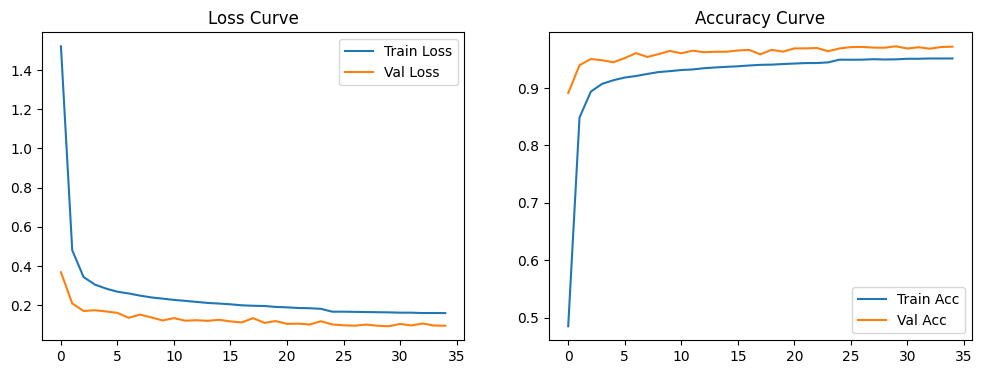

In [17]:
conv_configs = [
    {
        'type': 'conv',
        'in_channels': 1,          # MNIST灰度图通道数
        'out_channels': 16,       
        'kernel_size': 5,
        'stride': 1,
        'padding': 0,
        'weight_decay': True,      # 可选：添加正则化
        'weight_decay_lambda': 1e-4
    },
    {
        'type': 'pool',
        'pool_type': 'avg',
        'kernel_size': 2,
        'stride': 2
    },
    {
        'type': 'conv',
        'in_channels': 16,          # MNIST灰度图通道数
        'out_channels': 32,       
        'kernel_size': 5,
        'stride': 1,
        'padding': 0,
        'weight_decay': True,      # 可选：添加正则化
        'weight_decay_lambda': 1e-4
    },
    {
        'type': 'pool',
        'pool_type': 'avg',
        'kernel_size': 2,
        'stride': 2
    }
]

fc_configs = [
    (512, 10)  
]


trainer_cnn = train_model_cnn(conv_configs, fc_configs, False, 100, f'./saved_models/cnn_model_augmentation', 5)